#### Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor

#### Loading the data

In [2]:
df = pd.read_csv('melb_data.csv')
pd.set_option('max_columns', 21)
df.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


#### Dropping null values and features that are not relevant or are repetitive

In [3]:
cols = ['Distance', 'Propertycount', 'Lattitude', 'Longtitude', 'Postcode', 'Address', 'BuildingArea', 'CouncilArea']
df.drop(cols, axis=1, inplace=True)

In [4]:
df.replace('NaN', np.nan)
df.dropna(inplace=True)

#### Exploring the data

In [5]:
df.shape

(8174, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8174 entries, 1 to 13579
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Suburb      8174 non-null   object 
 1   Rooms       8174 non-null   int64  
 2   Type        8174 non-null   object 
 3   Price       8174 non-null   float64
 4   Method      8174 non-null   object 
 5   SellerG     8174 non-null   object 
 6   Date        8174 non-null   object 
 7   Bedroom2    8174 non-null   float64
 8   Bathroom    8174 non-null   float64
 9   Car         8174 non-null   float64
 10  Landsize    8174 non-null   float64
 11  YearBuilt   8174 non-null   float64
 12  Regionname  8174 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 894.0+ KB


In [7]:
df.describe()

,Rooms,Price,Bedroom2,Bathroom,Car,Landsize,YearBuilt
count,8174.000000,8.174000e+03,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000
mean,2.936384,1.064590e+06,2.912528,1.575728,1.590653,493.846954,1964.896501
std,0.980348,6.664493e+05,0.977194,0.705212,0.937045,990.013248,37.128773
min,1.000000,8.500000e+04,0.000000,0.000000,0.000000,0.000000,1196.000000
25%,2.000000,6.200000e+05,2.000000,1.000000,1.000000,158.000000,1940.000000
50%,3.000000,8.800000e+05,3.000000,1.000000,2.000000,389.500000,1970.000000
75%,4.000000,1.319375e+06,4.000000,2.000000,2.000000,641.000000,1999.000000
max,10.000000,9.000000e+06,10.000000,8.000000,10.000000,37000.000000,2018.000000


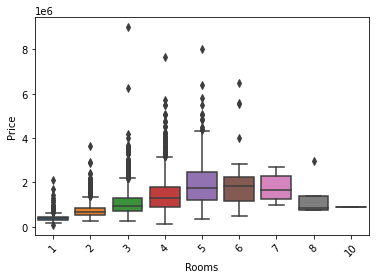

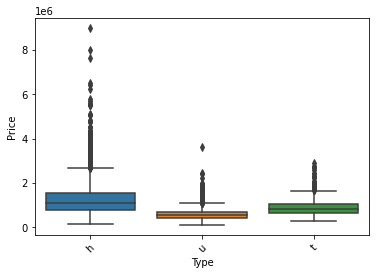

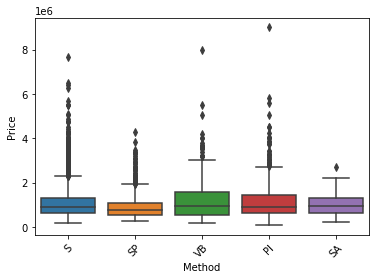

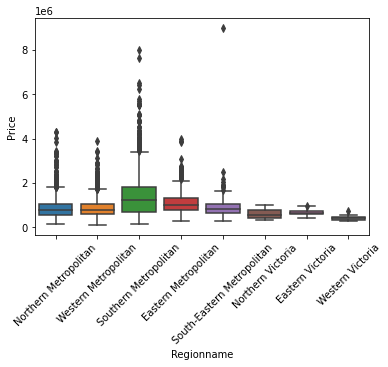

In [8]:
cols = ['Rooms', 'Type', 'Method', 'Regionname']
for col in cols:
    ax = sns.boxplot(x=col, y='Price', data=df)
    plt.xticks(rotation=45)
    
    plt.show()

<AxesSubplot:>

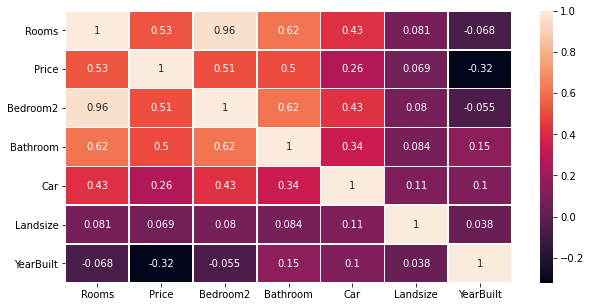

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True, linewidths=.5, ax=ax)

In [10]:
# Removing the irregularity of size of land being equal to 0

df = df[df['Landsize'] != 0]
df.shape

(6886, 13)

In [11]:
# Introducing new feature  for price per squarefoot

df['Price_per_sqft'] = df['Price'] / df['Landsize']
df.head(3)

,Suburb,Rooms,Type,Price,Method,SellerG,Date,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Regionname,Price_per_sqft
1,Abbotsford,2,h,1035000.0,S,Biggin,4/02/2016,2.0,1.0,0.0,156.0,1900.0,Northern Metropolitan,6634.615385
2,Abbotsford,3,h,1465000.0,SP,Biggin,4/03/2017,3.0,2.0,0.0,134.0,1900.0,Northern Metropolitan,10932.835821
4,Abbotsford,4,h,1600000.0,VB,Nelson,4/06/2016,3.0,1.0,2.0,120.0,2014.0,Northern Metropolitan,13333.333333


In [12]:
# Getting the descriptive statistics of the new feature

df['Price_per_sqft'].describe()

count      6886.000000
mean       3383.181201
std        7570.852998
min          15.810811
25%        1415.512584
50%        2497.239464
75%        4094.918504
max      440000.000000
Name: Price_per_sqft, dtype: float64

In [13]:
df[df['Rooms'] == 3]['Landsize'].value_counts()

697.0     21
534.0     17
585.0     17
275.0     17
217.0     14
          ..
775.0      1
931.0      1
799.0      1
1590.0     1
2385.0     1
Name: Landsize, Length: 851, dtype: int64

In [14]:
# Calculating the average square foot per room based on the five most popular sizes for 3 rooms
((534+697+585+275+217)/5)/3

153.86666666666667

In [15]:
#Getting only data that has average square foot per room >= 150
df = df[df['Landsize']/df['Rooms'] >= 150]
df.shape

(3220, 14)

In [16]:
df['Price_per_sqft'].describe()

count     3220.000000
mean      1698.909074
std       1050.702179
min         15.810811
25%       1000.000000
50%       1470.588235
75%       2203.541236
max      12096.774194
Name: Price_per_sqft, dtype: float64

In [17]:
# Removing outliers from our new data

def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('Suburb'):
        m = np.mean(subdf['Price_per_sqft'])
        st = np.std(subdf['Price_per_sqft'])
        reduced_df = subdf[(subdf['Price_per_sqft']>(m-st)) & (subdf['Price_per_sqft']<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df = remove_pps_outliers(df)
df.shape

(2230, 14)

In [18]:
df['Suburb'].value_counts()

Reservoir        62
Balwyn North     52
Preston          49
Glenroy          48
Glen Iris        46
                 ..
Bonbeach          1
Keysborough       1
Clayton South     1
Balaclava         1
Burwood East      1
Name: Suburb, Length: 244, dtype: int64

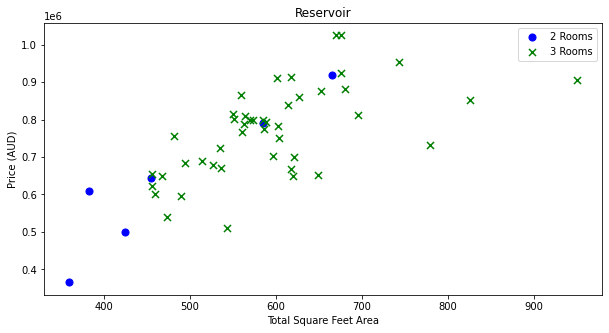

In [19]:
# Plotting scatter plot for 2 & 3 rooms to find outliers

def plot_scatter_chart(df, suburb):
    rm2 = df[(df['Suburb'] == suburb) & (df['Rooms'] == 2)]
    rm3 = df[(df['Suburb'] == suburb) & (df['Rooms'] == 3)]
    plt.rcParams['figure.figsize'] = (10,5)
    plt.scatter(rm2['Landsize'], rm2['Price'], color='blue', label='2 Rooms', s=50)
    plt.scatter(rm3['Landsize'], rm3['Price'], marker='x', color='green', label='3 Rooms', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (AUD)")
    plt.title(suburb)
    plt.legend()
    
plot_scatter_chart(df,"Reservoir")

In [20]:
# Removing room outliers

def remove_room_outliers(df):
    exclude_indices = np.array([])
    for suburb, suburb_df in df.groupby('Suburb'):
        rm_stats = {}
        for rm, rm_df in suburb_df.groupby('Rooms'):
            rm_stats[rm] = {
                'mean': np.mean(rm_df['Price_per_sqft']),
                'std': np.std(rm_df['Price_per_sqft']),
                'count': rm_df.shape[0]
            }
        for rm, rm_df in suburb_df.groupby('Rooms'):
            stats = rm_stats.get(rm-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, rm_df[rm_df['Price_per_sqft']<(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

df = remove_room_outliers(df)
df.shape

(1978, 14)

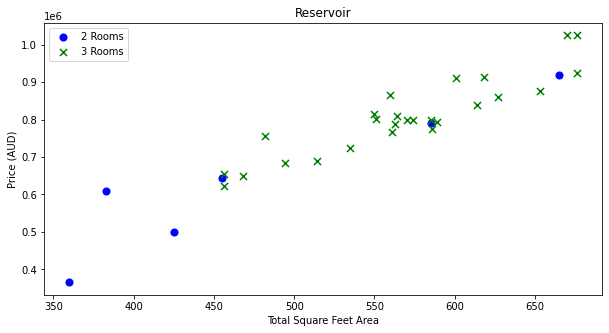

In [21]:
plot_scatter_chart(df,"Reservoir")

In [22]:
len(df['Suburb'].unique())

244

In [23]:
len(df['SellerG'].unique())

137

In [24]:
df['SellerG'].value_counts()

Barry            203
Nelson           179
Jellis           177
hockingstuart    173
Ray              116
                ... 
Ash                1
Hayeswinckle       1
Aquire             1
Peake              1
VICProp            1
Name: SellerG, Length: 137, dtype: int64

In [25]:
df['Suburb'].value_counts()

Glenroy           42
Bentleigh East    37
Balwyn North      36
Glen Iris         36
Reservoir         34
                  ..
Bonbeach           1
Keysborough        1
Clayton South      1
Balaclava          1
Burwood East       1
Name: Suburb, Length: 244, dtype: int64

In [26]:
df['Suburb'] = df['Suburb'].apply(lambda x : x.strip())
df['SellerG'] = df['SellerG'].apply(lambda x : x.strip())

In [27]:
suburb = df.groupby('Suburb')['Suburb'].agg('count').sort_values(ascending=False)
len(suburb[suburb < 10])

164

In [28]:
seller = df.groupby('SellerG')['SellerG'].agg('count').sort_values(ascending=False)
len(seller[seller < 10])

101

In [29]:
sub = suburb[suburb < 10]
sell = seller[seller < 10]

In [30]:
df['Suburb'] = df['Suburb'].apply(lambda x : 'Other' if x in sub else x)
df['SellerG'] = df['SellerG'].apply(lambda x : 'Other' if x in sell else x)

#### Encoding the features

In [31]:
df = pd.get_dummies(df)

X = df.drop('Price', axis=1)
y = df[['Price']]

#### Scaling the features

In [32]:
X = StandardScaler(with_mean=False).fit_transform(X)
y = StandardScaler().fit_transform(y)

#### Fitting different models and predicting

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [34]:
reg.score(X_test, y_test)

0.7705958536246716

In [35]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.76004072, 0.79884822, 0.82084436, 0.80075712, 0.77317849])

In [36]:
ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
ridge.score(X_test, y_test)

0.7779234079483108

In [37]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'ridge': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'Model': algo_name,
            'Best_score': gs.best_score_,
            'Best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['Model','Best_score','Best_params'])

find_best_model_using_gridsearchcv(X,y)

,Model,Best_score,Best_params
0,linear_regression,0.801199,{'normalize': True}
1,ridge,-0.001896,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.954227,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [38]:
# Saving the model into a pickle file
pickle.dump(reg, open('model.pickle', 'wb'))